# Übung 2: Data Extraction
In dieser Übung werden wir uns damit beschäftigen, wie wir mithilfe von Large Language Models (LLMs) wertvolle Informationen aus großen Mengen Textdaten extrahieren können.

Anhand eines realen Beispiels aus dem Bereich der Immobilienfinanzierungen werden wir einen Marktbericht strukturiert auslesen.

## Setup

In [ ]:
!pip install haystack-ai "sentence-transformers>=3.0.0" pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.0/380.0 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.1 MB/s eta 0:00:00


## Aufgabe

### Situation
Ihr seid als Transaction Manager einer Bank im Bereich strukturierte Finanzierungen eingestellt. Eure Aufgabe ist es, Kreditanträge für Büroimmobilien zu bearbeiten und eine Entscheidungsvorlage für das Management auszuarbeiten. Essentieller Bestandteil ist eine Marktanalyse, die den Markt makroökonomisch betrachtet sowie Chancen und Risiken ausarbeitet.

Dein Vorgestzter beauftragt dich, eine Marktanalyse für eine Immobilie in Frankfurt am Main zu erstellen. Diese liegt im Bankenviertel nahe der Taunusanlage.

### Aufgabenstellung
Erstelle eine Marktanalyse, die den Verlauf der Mieten sowie den Leerstand zusammenfasst. Von besonderer Bedeutung sind hier die Citylagen. Leite Chancen und Risiken ab.

**Optional:** Was sind die grenzen des gewählten technischen Ansatzes?

## Data Extraction

### Schritt 1 - Daten beziehen
Erster Schritt einer Datenextraktionspipeline ist die Anbindung der zu extrahierenden Daten. In unserem Fall nutzen wir Dateien aus dem Internet. Die Komponente `LinkContentFetcher`
der von uns verwendeten Bibliothek Haystack lädt den Content hinter einem Link und gibt diesen an die weiteren Schritte zur Verarbeitung weiter.

In [ ]:
from haystack.components.fetchers import LinkContentFetcher

pdf_fetcher = LinkContentFetcher()

### Schritt 2 - PDF in Text umwandeln
Da wir in unserem Fall auf PDF-Dokumente zurückgreifen, müssen diese erst in lesbaren Text umgewandelt werden. Hierfür greifen wir auf die Komponente `PyPDFToDocument` zurück.

In [ ]:
from haystack.components.converters import PyPDFToDocument

pdf_converter = PyPDFToDocument()


### Schritt 3 - Prompt erstellen
Die Inhalte der Dokumente werden anschließend in eine Prompt eingefügt. Die Komponenten Das Prompt-Template des `PromptBuilder` enthält Variablen, die zur Laufzeit durch die Inhalte der eingelesenen Dokumente ersetzt werden.

In [ ]:
prompt_template = """
Do stuff with the following context.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}
"""

In [ ]:
from haystack.components.builders import PromptBuilder

prompt_builder = PromptBuilder(template=prompt_template)

### Schritt 4 - Prompt an ein LLM schicken
Der generierte Prompt wird anschließend an ein Large Language Model (hier: gpt-4o) geschickt. Dieses LLM wird in diesem Schritt definiert.

In [ ]:
import os
from getpass import getpass
from haystack import Pipeline
from haystack.components.generators import AzureOpenAIGenerator
from haystack.utils import Secret

azure_endpoint = "https://cofinpro-training-openai-studio.openai.azure.com/"
azure_deployment = "gpt-4o"


api_key = getpass("Enter OpenAI API key:")

generator = AzureOpenAIGenerator(
    azure_endpoint=azure_endpoint,
    azure_deployment=azure_deployment,
    api_key=Secret.from_token(api_key)
)

/usr/local/lib/python3.10/dist-packages/haystack/core/errors.py:34: DeprecationWarning: PipelineMaxLoops is deprecated and will be remove in version '2.7.0'; use PipelineMaxComponentRuns instead.
  warnings.warn(


Enter OpenAI API key:··········


### Schritt 5 - Komponenten verknüpfen
In diesem Schritt werden die vorher definierten Komponenten in einer Pipeline miteinander verknüpft.

Bei Ausführung erhält die Pipeline Links zu PDF-Dokumenten und führt anschließend alle definierten Schritte nacheinander durch.

In [ ]:
pipeline = Pipeline()
pipeline.add_component("load_pdf", pdf_fetcher)
pipeline.add_component("convert_pdf", pdf_converter)
pipeline.add_component("build_prompt", prompt_builder)
pipeline.add_component("generate_results", generator)

pipeline.connect("load_pdf", "convert_pdf")
pipeline.connect("convert_pdf", "build_prompt.documents")
pipeline.connect("build_prompt", "generate_results")

🚅 Components
  - load_pdf: LinkContentFetcher
  - convert_pdf: PyPDFToDocument
  - build_prompt: PromptBuilder
  - generate_results: AzureOpenAIGenerator
🛤️ Connections
  - load_pdf.streams -> convert_pdf.sources (List[ByteStream])
  - convert_pdf.documents -> build_prompt.documents (List[Document])
  - build_prompt.prompt -> generate_results.prompt (str)

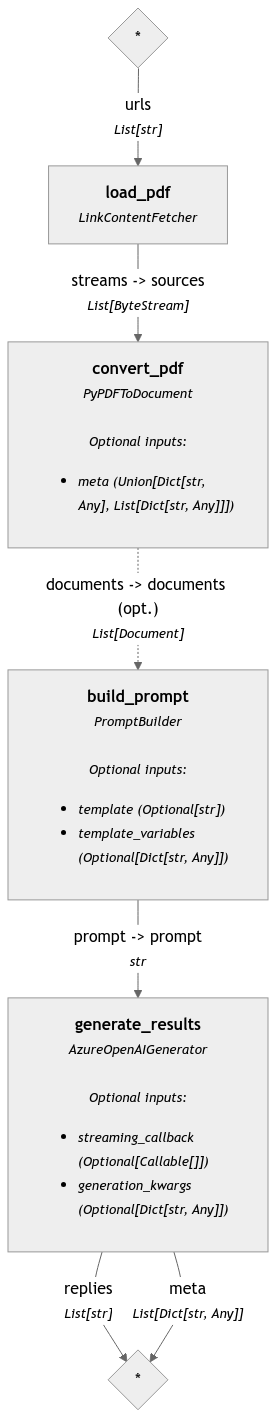

In [ ]:
pipeline.show()

### Schritt 6 - Ausführen der Pipeline
Die Pipeline wird für die angegebene URL ausgeführt und die Ergebnisse zurückgegeben.

In [ ]:
from IPython.display import display, Markdown
url = "https://www.realestate.bnpparibas.de/sites/default/files/document/2024-10/bnppre-bueroimmobilienmarkt-frankfurt-2024q3.pdf"

result = pipeline.run(
        {
            "load_pdf": {"urls": [url]}
        }
    )
display(Markdown(result["generate_results"]["replies"][0]))

1. **How much did the space turnover in Frankfurt's office market increase in the first three quarters of 2024 compared to the previous year?**

   The space turnover in Frankfurt's office market increased by around 8% in the first three quarters of 2024 compared to the previous year.

2. **Which sector had the highest participation in the market activity in terms of space turnover?**

   The financial sector, driven by the major contract with the European Central Bank (EZB), had the highest participation in market activity with nearly 26% of the space turnover.

3. **What is the current prime rent in Frankfurt's office market?**

   The current prime rent in Frankfurt's office market is 49.00 €/m².

4. **How much did the total vacancy increase year-on-year, and what is the total current vacancy?**

   The total vacancy increased by approximately 13% year-on-year, reaching 1.6 million m².

5. **What was the average rent at the end of September 2024?**

   The average rent at the end of September 2024 was 24.20 €/m².

6. **What percentage of the total space turnover came from central or well-connected office locations in Frankfurt?**

   About 45% of the total space turnover came from central or well-connected office locations in Frankfurt.

7. **Which office submarket had the highest individual space turnover and why?**

   The Bankenviertel (Banking District) had the highest individual space turnover at 73,000 m², significantly benefiting from the major lease of nearly 37,000 m² by the EZB.

8. **What is the forecasted total space turnover for the entire year of 2024?**

   The forecasted total space turnover for the entire year of 2024 is around 450,000 m².

9. **What is the current vacancy rate in the Frankfurt office market and the gif-market area?**

   The current vacancy rate in both the Frankfurt office market and the gif-market area is 10.4%.

10. **What significant development can be noted about contracts over 5,000 m² in 2024?**

    Contracts over 5,000 m² showed an above-average increase, serving as a positive signal amidst generally fewer large deals, yet the majority of space turnover was generated in the smaller and medium-sized categories (up to 5,000 m²) indicating a broad demand spectrum.